## Report on Experiment with Deceptive Kernel using RockSample Problem

### RockSample Problem: 

<a id='rocksample'></a>

"A scalable problem that models rover science exploration. The rover can achieve reward by sampling rocks in the immediate area, and by continuing its traverse (reaching the exit at the right side of the map). The positions of the rover and the rocks are known, but only some of the rocks have scientific value; we will call these rocks “good”. Sampling a rock is expensive, so the rover is equipped with a noisy long-range sensor that it can use to help determine whether a rock is good before choosing whether to approach and
sample it."

- [link to original paper](https://arxiv.org/ftp/arxiv/papers/1207/1207.4166.pdf)

- [link to Julia Implementation](https://github.com/JuliaPOMDP/RockSample.jl)

Example run in Gif:
<img src="img/rocksample.gif" width=360 height=360 />

Map environment used in experiment:
<img src="img/rocksample.JPG" width=300 height=300 />

[Jump to heatmap of Analysis part 5](#p5_con)

Mark Notations
- S: start position:
- 0-7: eight fixed rock positions
- G: exit area, when reached, enter exit state.

Agent's allowed actions:
- North, South, East, West: moving 1 step according to the direction
- Check-i, $i\in[0,7]$, check $i-th$ rock to see if the rock is good or not
- Sample, sample the rock at current position.

Observations:
- EMPTY: when taking a moving, or a sampling action, agent gets notified that the rock at current position is EMPTY
- Good/bad: when taking a Check-i action, agent get notified if the $i-th$ rock is good or not. The information is noisy.

Rewards:
- Successfully sample a good rock: +10.0
- Sample a bad rock: -10.0
- enter exit state (goal): +10.0 

Player's belief:
- (Position, RockStates)

Position is player's current location in the map, RockStates is player's belief over eight rocks' states (whether good or bad)
- A example belief $b = ((3,0), [1,0,1,0,0,0,1,0])$, agent is located at (3,0) and believes rocks 0,2,6 are good ones.


### Deceptive Approach

Because only the observation after "Check" action is informative to the agent, we will apply three kinds of deceptive observative kernel - [Prob, Rand, Oppo] to all these observation. The observation is either good (1) or bad (0) for the target rock.

Assume the original noisy observation is $O$, the true observation is $O_T$, the false observation is $O_F = 1 - O_T$. Original observation is more noisy when distance between agents and the rock. Assume at a certain distance, the correct rate of observation is $p$:
- $ O = p * O_T + (1 - p) * O_F$ 
- $Prob(O) = (0.85p) * O_T + (1-0.85p) * O_F$
- $Rand(O) = 0.5* O_T + 0.5* O_F$
- $Oppo(O) = O_F$

[Jump to start of analysis](#analysis_start)

In [1]:
import numpy as np
import os
import json
import pandas as pd

In [2]:
path = './temp/rsample_res/out/'

base_fn = ['BASE_500', 'BASE_200_s4k']
prob_fn = ['PROB_500', 'PROB_200_s4k']
rand_fn = ['RAND_500', 'RAND_200_s4k']
oppo_fn = ['OPPO_500', 'OPPO_200_s4k']
exp_fns = [base_fn, prob_fn, rand_fn, oppo_fn]
titles = list(zip(*exp_fns))

suffix = '.out'

In [3]:
unit_head = 'RockModel'
display_head = 'Displaying'
step_head = 'id:'
unit_result_head = 'Epoch'
med_bar = '='*42
large_bar = '='*70

state_head = 'Ro'
ignore_heads = ['ag','Be']
step_heads = ['id', 'ac', 'ob', 'ne', 're']
title_heads = '\t'

In [4]:
def strip_split_head(line, delim):
    return line.strip().split(delim)[0]

def parse_actual_state(line):
    array_str = line.strip().split('=')[-1].strip()
    array = json.loads(array_str)
    array = [0 if x==0 else 1 for x in array]
    return array

def parse_last(line, typ):
    last_str = line.strip().split()[-1]
    return typ(last_str)

def parse_id(line):
    return parse_last(line, int)

def parse_act(line):
    tar_rock = -1
    act_pair = parse_last(line, str).split('-')
    if len(act_pair) == 2:
        tar_rock = int(act_pair[1])
    return (act_pair[0], tar_rock)

def parse_obs(line):
    obs = parse_last(line, str).split('-')
    isFalse = False
    isDeceived = False
    if len(obs) == 3:
        return (obs[0], True, True)
    elif len(obs) == 2:
        if obs[1][0] == 'D':
            isDeceived = True
        elif obs[1][0] == 'F':
            isFalse = True
    #if isDeceived and (not isFalse):
    #    print("Interesting happens")
    return (obs[0], isFalse, isDeceived)

def parse_state(line):
    state_str = line.strip().split(':')[-1]
    pos, rocks = state_str.split('-')
    pos = eval(pos)
    rocks = [int(i) for i in rocks.strip().split()]
    return pos, rocks

def parse_rew(line):
    return parse_last(line, float)

def parse_return_value(line):
    return parse_last(line, float)


In [5]:
'''
    Pre-info
    Ro
    k*steps
    k*steps
    Epoch-res
        epoch-discounted
        epoch-undiscounted

    epoch: {
        epoch_no:
        step: {id: , act: , obs: , state: {pos: , rock: }, rew: },
        ...
        discounted: ,
        undiscounted: ,
        steps: 
    }
'''

def parse(path):
    ep_count = 0
    step_count = 0
    
    collection = {}
    temp_epoch = None
    temp_step = None
    steps = None
    
    with open(path, 'r') as file:
        for line in file:
            
            if line[:2] == state_head:
                # put previous epoch in collection
                temp_epoch = dict()
                steps = dict()
                ep_count += 1
                temp_epoch['rock_state'] = parse_actual_state(line)
                #print(actual_state)
            
            elif line[:2] == 'id':
                temp_step = dict()
                assert (parse_id(line)==step_count), "step id and counter don't match."
                        
            elif line[:2] == 'ac':
                temp_step['act'] = parse_act(line)
                
            elif line[:2] == 'ob':
                temp_step['obs'] = parse_obs(line)
                
            elif line[:2] == 'ne':
                pos, rocks = parse_state(line)
                temp_step['state'] = {'pos': pos, 'rocks': rocks}
                
            elif line[:2] == 're':
                temp_step['rew'] = parse_rew(line)
                steps[step_count] = temp_step
                temp_step = None
                step_count += 1

            elif line[0] == '\t':
                line = line.strip().split()
                if line[0] == unit_result_head:
                    epoch_no = int(line[1].strip('#'))
                    assert (epoch_no == ep_count), "epoch no and counter don't match."
                    temp_epoch['epoch_no'] = epoch_no
            
            elif line[:2] == '**':
                temp_epoch['d_return'] = parse_return_value(line)
            
            elif line[:2] == '##':
                temp_epoch['u_return'] = parse_return_value(line)
                temp_epoch['steps'] = steps
                if ep_count > 0:
                    collection[ep_count] = temp_epoch
                    temp_epoch = None
                    steps = None
                    step_count = 0
            
    file.close()
    return collection

In [6]:
base_res = parse(path+base_fn[0]+suffix)
base_200_res = parse(path+base_fn[1]+suffix)
#base_res[1]

In [7]:
prob_res = parse(path+prob_fn[0]+suffix)
prob_200_res = parse(path+prob_fn[1]+suffix)

In [8]:
rand_res = parse(path+rand_fn[0]+suffix)
rand_200_res = parse(path+rand_fn[1]+suffix)

In [9]:
oppo_res = parse(path+oppo_fn[0]+suffix)
oppo_200_res = parse(path+oppo_fn[1]+suffix)

<a id='analysis_start'></a>
## Sub-topics of Analysis in Validating the Deceptive Approaches

1. Distance between actual rock state, and player's belief state throughout
    - Is the distance larger, or potentially getting larger under the influence of deception
    - [link to Part 1](#Part_1)


2. Number of Falsified observation and Deceived observation
    - Is the number of F/D observation correlated with player's final rewards
    - [link to Part 2](#Part_2)
   

3. Number of steps in each epoch
    - Does deceptive kernel prolong/shorten the running epoch
    - [link to Part 3](#Part_3)
   

4. Critical steps (rewarding sample steps) affected by deception
        
    - Agent's belief changes incurred by deception
        - the deceptive observation is potentially served to each CHECK action and affect agent's belief towards a rock's status
        - when previous belief is neg, a pos observation could switch the belief to pos
        - when previous belief is pos, a neg observation could switch the belief to nge
        
    - Wrong Sampling actions taken, potentially incurred by falsified/deceptive observation
        - neg obs, later visit but no sample
        - pos obs, later visit and mis-sample

    - [link to Part 4](#Part_4)
    

5. Path taken by the agent, in the form of heatmaps
    - [link to Part 5](#Part_5)

In [10]:
import matplotlib.pyplot as plt
from functools import reduce
from statistics import mean

In [11]:
rock_positions = [(0,1), (0,4), (1,0), (3,1), 
                  (3,4), (4,1), (5,0), (6,3)]
rocks = dict(zip(range(8), rock_positions))

observe_dict = {'Bad': False, 'Good': True, 'EMPTY': -1}
#print(rocks)

In [12]:
# 1
def belief_dist(s1, s2):
    dist = 0
    for i, j in zip(s1, s2):
        if i != j:
            dist += 1
    return dist

def get_dist_stat(experiment):
    distance_dic = dict()
    for epoch in experiment.values():
        steps = epoch['steps']
        actual_state = epoch['rock_state']
        state_list = [s['state']['rocks'] for s in steps.values()]
        dist_list = [belief_dist(actual_state, s) for s in state_list]
        distance_dic[epoch['epoch_no']] = dist_list
    return distance_dic

def check_trend(dist_lst):
    isInc = True
    isDec = True
    for i in range(len(dist_lst)-1):
        if dist_lst[i+1] > dist_lst[i]:
            isDec = False
        if dist_lst[i+1] < dist_lst[i]:
            isInc = False
    return (isInc, isDec)

def analyze_dist(dist_dict):
    dists = []
    # [increasing_count, decreasing_count, fluctuate_count, constant_count]
    trend_stat = [0]*4
    for v in dist_dict.values():
        dists.append(sum(v) / len(v))
        isInc, isDec = check_trend(v)
        if isInc and isDec:
            trend_stat[3] += 1
        elif isInc:
            trend_stat[0] += 1
        elif isDec:
            trend_stat[1] += 1
        else:
            trend_stat[2] += 1
        
    return (sum(dists)/len(dists)), trend_stat 
    
#2
def get_obs_stat(experiment):
    obs_stat_dict = dict()
    for epoch in experiment.values():
        f_count = 0
        d_count = 0
        fd_count = 0
        others = 0
        steps = epoch['steps']
        obs_list = [s['obs'] for s in steps.values()]
        for _, isF, isD in obs_list:
            if isF and isD:
                fd_count += 1
            elif isF:
                f_count += 1
            elif isD:
                d_count += 1
            else:
                others += 1
        obs_stat_dict[epoch['epoch_no']] = (f_count, d_count, fd_count, others)
    return obs_stat_dict

def analyze_obs_stat(obs_stat_dict, exp_result):
    deception_rates = []
    falsified_rates = []
    undiscounted = []
    discounted = []
    
    for k, v in obs_stat_dict.items():
        deception_rates.append((v[1]+v[2])/sum(v))
        falsified_rates.append((v[0]+v[2])/sum(v))
        undiscounted.append(exp_result[k]['u_return'])
        discounted.append(exp_result[k]['d_return'])
        
    return (deception_rates, falsified_rates, \
           undiscounted, discounted)

def plot_2d_hists(tuples_of_lst, figsize, bins, titles):
    _, axs = plt.subplots(1, len(tuples_of_lst),  figsize=figsize)
    for i in range(len(tuples_of_lst)):
        x_values, y_values = tuples_of_lst[i]
        axs[i].hist2d(x_values, y_values, bins=bins)
        axs[i].title.set_text(titles[i])
        

# 3
def get_steps_no(experiment):
    steps_no_dict = dict()
    for epoch in experiment.values():
        steps_no_dict[epoch['epoch_no']] = len(epoch['steps'])
    return steps_no_dict

# 4
'''
    check_list: {step_no: rock_no}
    path: {step_no: position}
    samples: {step_no: rock_no/-1}
    observe_list: {step_no: (target, result, isFalsified, isDeceptive, prev_belief, next_belief)}
'''
def get_path_info_epoch(epoch):
    check_list = dict()
    path = {0:(3,0)}
    samples = dict()
    observe_list = dict()
    steps = epoch['steps']
    for k, v in steps.items():
        act, target = v['act']
        if act == 'CHECK':
            check_list[k] = target
            obs = v['obs']
            # let prev_belief be -1
            prev_belief = -1
            # if not the first step
            if k > 0:
                prev_belief = steps[k-1]['state']['rocks'][target]
            next_belief = v['state']['rocks'][target]
            # (target, result[T/F], isF, isD, prev_b, next_b)
            observe_list[k] = (target, observe_dict[obs[0]], obs[1], \
                              obs[2], prev_belief, next_belief)
        elif act == 'SAMPLE':
            if v['state']['pos'] in rock_positions:
                samples[k] = rock_positions.index(v['state']['pos'])
            else:
                samples[k] = -1
        else:
            path[k+1] = v['state']['pos']
    return check_list, path, samples, observe_list


'''
    check_list: {step_no: rock_no}
    path: {step_no: position}
    samples: {step_no: rock_no/-1}
    observe_list: {step_no: (target, result, isFalsified, isDeceptive, prev_belief, next_belief)}
'''
def analyze_observation_epoch(check_list, path, samples, observe_list):
    
    #[[TP, TN], 
    # [FP, FN]]
    normal_stat = np.zeros((2,2))
    decept_stat = np.zeros((2,2))
    # ignore_count for counting positive observation but no visit
    normal_ignore_count = 0
    decept_ignore_count = 0

    for step, obs in observe_list.items():
        # target, result_of_obs, isFalsified, isDeceived, prev_belief, next_belief
        # [0-7], bool, bool, bool, (0,1), (0,1)
        target, result, isF, isD, _, _ = obs
        
        if not isD: # not deceived
            if result: # observe positive for the rock
                path_after = [pos for s, pos in path.items() if s > step]
                # if visited the position later
                if rock_positions[target] in path_after: 
                    sample_after = [tar for s, tar in samples.items() if s > step]
                    # if sampled the position later - TP
                    if target in sample_after:
                        normal_stat[0,0] += 1
                    else: # observe but not sample - TN
                        normal_stat[0,1] += 1
                else: # never visit the position - ignore
                    normal_ignore_count += 1
            else: # observe negative for the rock
                sample_after = [tar for s, tar in samples.items() if s > step]
                # observe neg but still sampled - FP
                if target in sample_after:
                    normal_stat[1,0] += 1
                else: # observe neg and no sample - FN
                    normal_stat[1,1] += 1
        
        else: # the observation is deceived
            if result: # observe positive for the rock
                path_after = [pos for s, pos in path.items() if s > step]
                # if visited the position later
                if rock_positions[target] in path_after: 
                    sample_after = [tar for s, tar in samples.items() if s > step]
                    # if sampled the position later - TP
                    if target in sample_after:
                        decept_stat[0,0] += 1
                    else: # observe but not sample - TN
                        decept_stat[0,1] += 1
                else: # never visit the position - ignore
                    decept_ignore_count += 1
            else: # observe negative for the rock
                sample_after = [tar for s, tar in samples.items() if s > step]
                # observe neg but still sampled - FP
                if target in sample_after:
                    decept_stat[1,0] += 1
                else: # observe neg and no sample - FN
                    decept_stat[1,1] += 1
    return normal_stat, normal_ignore_count, decept_stat, decept_ignore_count


                
'''
    Get the statistics for belief-changing cases during experiment, 
    and analyze if deception contributes to more cases.
'''                
def belief_change(observe_list):
    # BC stands for belief_change
    BC_count = 0
    falsified_BC_count = 0
    deceived_BC_count = 0
    
    for step, obs in observe_list.items():
        if step > 0 and obs[4] != obs[5]:
            BC_count += 1
            if obs[2]:
                falsified_BC_count += 1
                if obs[3]:
                    deceived_BC_count += 1
    return [len(observe_list), BC_count, falsified_BC_count, deceived_BC_count]


def analyze_observation_exp(experiment):
    normal_stat = np.zeros((2,2))
    decept_stat = np.zeros((2,2))
    
    normal_ig_count = 0
    decept_ig_count = 0
    
    belief_change_stat = np.zeros(4)
    
    for epoch_no, epoch in experiment.items():
        check_list, paths, samples, observe_list = get_path_info_epoch(epoch)
        bc_result = belief_change(observe_list)
        #print(bc_result)
        belief_change_stat += bc_result
        
        n_stat_ep, n_ignore_count_ep, d_stat_ep, d_ignore_count_ep = \
            analyze_observation_epoch(check_list, paths, samples, observe_list)
        #print(n_stat_ep, d_stat_ep, n_ignore_count_ep, d_ignore_count_ep)
        normal_stat += n_stat_ep
        decept_stat += d_stat_ep
        normal_ig_count += n_ignore_count_ep
        decept_ig_count += d_ignore_count_ep
    #print("Final\n")
    #print(normal_stat, decept_stat, normal_ig_count, decept_ig_count)
    return normal_stat, decept_stat, normal_ig_count, decept_ig_count, belief_change_stat
    
# generate heatmap
'''
    path: {step_no: position}
    samples: {step_no: rock_no/-1}
'''
def generate_heatmap(experiment):
    heatmap = np.zeros((7,7))
    sample_map = np.zeros((7,7))
    for k, v in experiment.items():
        _, path, samples, _ = get_path_info_epoch(v)
        for pos in path.values():
            heatmap[pos] += 1
        for rock_no in samples.values():
            if rock_no != -1:
                sample_map[rock_positions[rock_no]] += 1
    heatmap = heatmap / len(experiment)
    sample_map = sample_map / len(experiment)
    return heatmap, sample_map


def show_heatmaps(exp_set, figsize, titles):
    fig, axs = plt.subplots(2, len(exp_set), figsize=figsize)
    
    for k, exp in enumerate(exp_set):
        heatmap, sample_map = generate_heatmap(exp)
        im = axs[0, k].imshow(heatmap)
        # Loop over data dimensions and create text annotations.
        for i in range(heatmap.shape[0]):
            for j in range(heatmap.shape[1]):
                text = axs[0, k].text(j, i, heatmap[i, j],\
                        ha="center", va="center", color="w")
                
        im = axs[1, k].imshow(sample_map)
        # Loop over data dimensions and create text annotations.
        for i in range(sample_map.shape[0]):
            for j in range(sample_map.shape[1]):
                text = axs[1, k].text(j, i, sample_map[i, j],\
                        ha="center", va="center", color="w")

        axs[0, k].set_title(titles[k])
        axs[1, k].set_title(titles[k])
    fig.tight_layout()
    plt.show()


<a id='Part_1'></a>
### Analysis Part 1

Define the scalar 'distance' to be the difference between the actual rock status and agent's belief. We try to evaluate if the deceptive observations successfully 'mis-guide' the agent by driving agent's belief further to the actual rock status.

- [Jump back to start](#analysis_start)
- [Jump to conclusion](#p1_con)

In [13]:
# analysis part 1
dist_print_msg = "Experiment: {}, average dist: {:.2f}; \n \
-- Increasing: {}, decreasing: {}, fluctuate: {}, constant: {}"

In [14]:
base_500_dist = get_dist_stat(base_res)
base_200_dist = get_dist_stat(base_200_res)

avg, trend = analyze_dist(base_500_dist)
print(dist_print_msg.format(base_fn[0], avg, *trend))

avg, trend = analyze_dist(base_200_dist)
print(dist_print_msg.format(base_fn[1], avg, *trend))

Experiment: BASE_500, average dist: 3.80; 
 -- Increasing: 167, decreasing: 33, fluctuate: 268, constant: 32
Experiment: BASE_200_s4k, average dist: 4.03; 
 -- Increasing: 64, decreasing: 16, fluctuate: 101, constant: 19


In [15]:
prob_500_dist = get_dist_stat(prob_res)
prob_200_dist = get_dist_stat(prob_200_res)

avg, trend = analyze_dist(prob_500_dist)
print(dist_print_msg.format(prob_fn[0], avg, *trend))

avg, trend = analyze_dist(prob_200_dist)
print(dist_print_msg.format(prob_fn[1], avg, *trend))

Experiment: PROB_500, average dist: 3.97; 
 -- Increasing: 155, decreasing: 28, fluctuate: 270, constant: 47
Experiment: PROB_200_s4k, average dist: 3.82; 
 -- Increasing: 41, decreasing: 11, fluctuate: 131, constant: 17


In [16]:
rand_500_dist = get_dist_stat(rand_res)
rand_200_dist = get_dist_stat(rand_200_res)

avg, trend = analyze_dist(rand_500_dist)
print(dist_print_msg.format(rand_fn[0], avg, *trend))

avg, trend = analyze_dist(rand_200_dist)
print(dist_print_msg.format(rand_fn[1], avg, *trend))

Experiment: RAND_500, average dist: 4.15; 
 -- Increasing: 93, decreasing: 44, fluctuate: 287, constant: 76
Experiment: RAND_200_s4k, average dist: 4.19; 
 -- Increasing: 43, decreasing: 13, fluctuate: 104, constant: 40


In [17]:
oppo_500_dist = get_dist_stat(oppo_res)
oppo_200_dist = get_dist_stat(oppo_200_res)

avg, trend = analyze_dist(oppo_500_dist)
print(dist_print_msg.format(oppo_fn[0], avg, *trend))

avg, trend = analyze_dist(oppo_200_dist)
print(dist_print_msg.format(oppo_fn[1], avg, *trend))

Experiment: OPPO_500, average dist: 5.43; 
 -- Increasing: 339, decreasing: 0, fluctuate: 0, constant: 161
Experiment: OPPO_200_s4k, average dist: 5.46; 
 -- Increasing: 128, decreasing: 0, fluctuate: 0, constant: 72


<a id='p1_con'></a>
### Conclusion - Part 1

Compared to Baseline model without deception:

1. Prob kernel doesn't seem to affect the player's belief distance or the trend of distance during decision-making
2. With Rand kernel, the distance is averagely longer to the actual rock states, and there are more cases where the distance never changes. This means that in more cases, player never changes his belief regarding rock states. The reason has two folds. The Rand kernel disguises the agent so that it is harder to have a certain belief towards a rock, as a result of unstable feedback/observation from 'Checking'. Secondly, the agent takes fewer SAMPLE actions. 
3. With Oppo kernel, the average distance value is significantly larger. In significantly more cases, the distance shows an increasing trend throughout rollout. Reason is straightforward because all the observation are falsified. The distance would never get shorter if player has a even wrong belief towards the rock.

[Jump back to start](#analysis_start)

<a id='Part_2'></a>
### Analysis Part 2

We try to discuss if the discounted/undiscounted return is correlated to falsified/deceived rate of observation received by the agent during experiments.

- [Jump back to start](#analysis_start)
- [Jump to conclusion](#p2_con)

In [18]:
experiment_set_500 = [base_res, prob_res, rand_res, oppo_res]
experiment_set_200 = [base_200_res, prob_200_res, rand_200_res, oppo_200_res]

reward_print_msg = \
"Experiment: {}, avg undiscounted return: {:.2f}, avg discounted return: {:.2f};\n\
-- Undiscounted range: [{:.2f}, {:.2f}], discounted range: [{:.2f}, {:.2f}]\n"

In [19]:
lists_collection = []
for i, exp in enumerate(experiment_set_500):
    obs_stat_dict = get_obs_stat(exp)
    # deception_rates, falsified_rates, undiscounted, discounted
    exp_lsts = list(analyze_obs_stat(obs_stat_dict, exp))
    print(reward_print_msg.format(titles[0][i], mean(exp_lsts[2]), mean(exp_lsts[3]),\
        min(exp_lsts[2]), max(exp_lsts[2]), min(exp_lsts[3]), max(exp_lsts[3])))
    lists_collection.append(exp_lsts)
    
collection_array = np.asarray(lists_collection)

Experiment: BASE_500, avg undiscounted return: 23.42, avg discounted return: 15.26;
-- Undiscounted range: [10.00, 60.00], discounted range: [2.15, 28.18]

Experiment: PROB_500, avg undiscounted return: 21.34, avg discounted return: 13.78;
-- Undiscounted range: [0.00, 50.00], discounted range: [-2.39, 27.80]

Experiment: RAND_500, avg undiscounted return: 15.68, avg discounted return: 8.93;
-- Undiscounted range: [0.00, 40.00], discounted range: [-2.33, 22.00]

Experiment: OPPO_500, avg undiscounted return: 10.04, avg discounted return: 5.68;
-- Undiscounted range: [10.00, 20.00], discounted range: [0.51, 16.48]



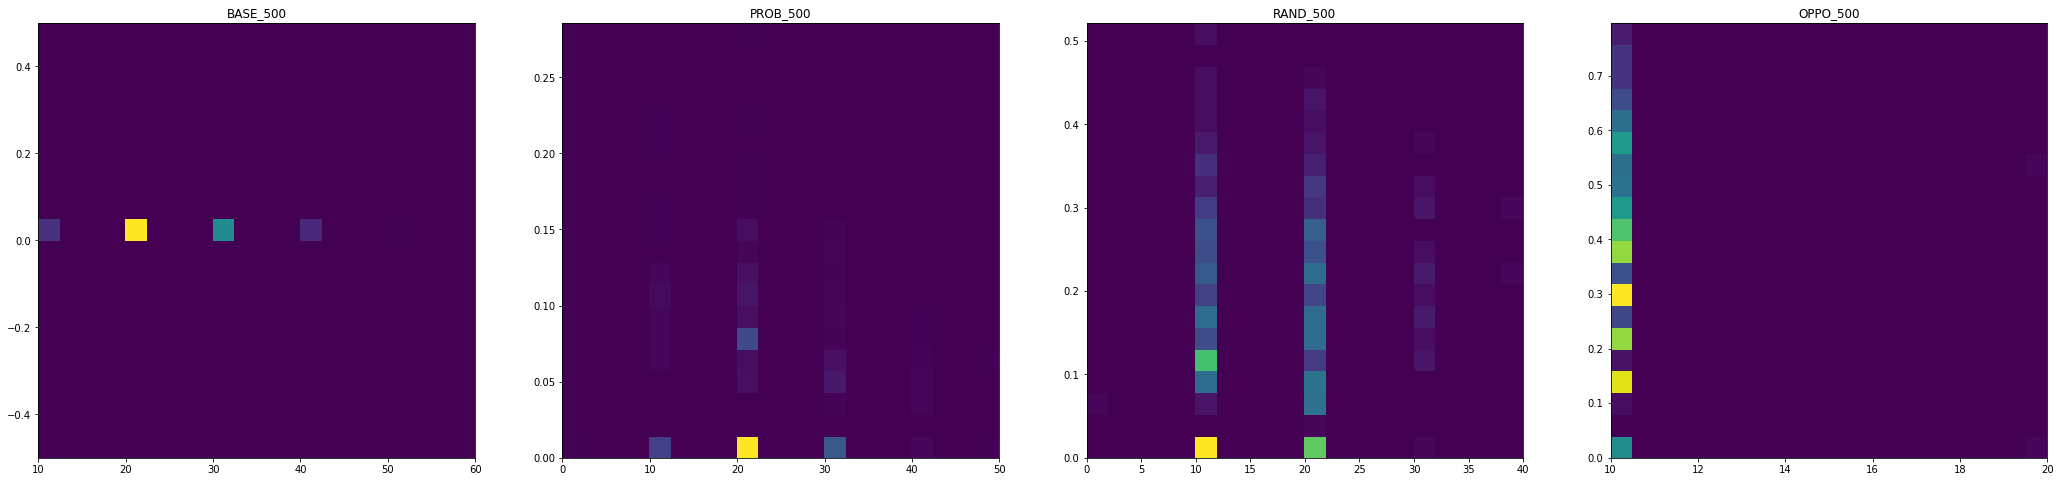

In [20]:
# visualize the histogram of "deception rates" over "undiscounted rewards"
plot_2d_hists(collection_array[:, [2, 0], :].tolist(), (36,8), 20, titles[0])

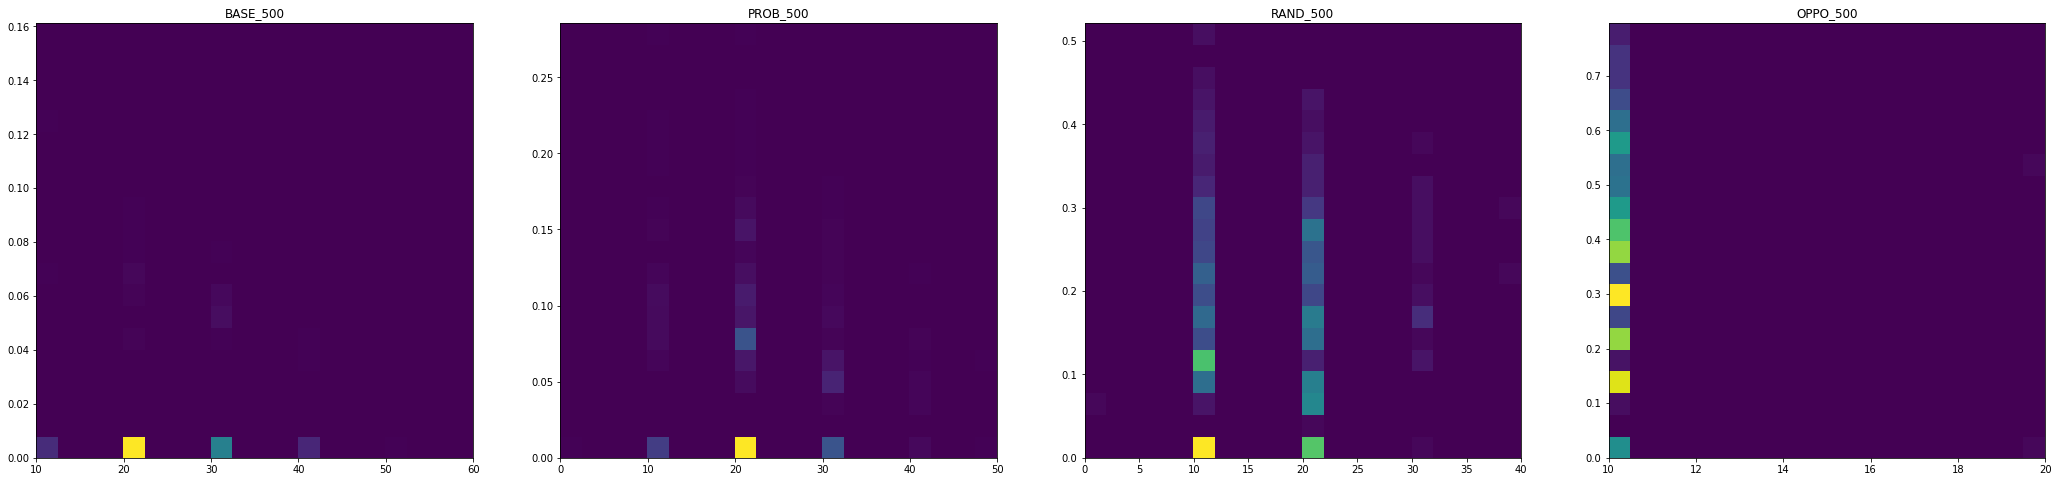

In [21]:
# visualize the histogram of "falsified rates" over "undiscounted rewards"
plot_2d_hists(collection_array[:, [2, 1], :].tolist(), (36,8), 20, titles[0])

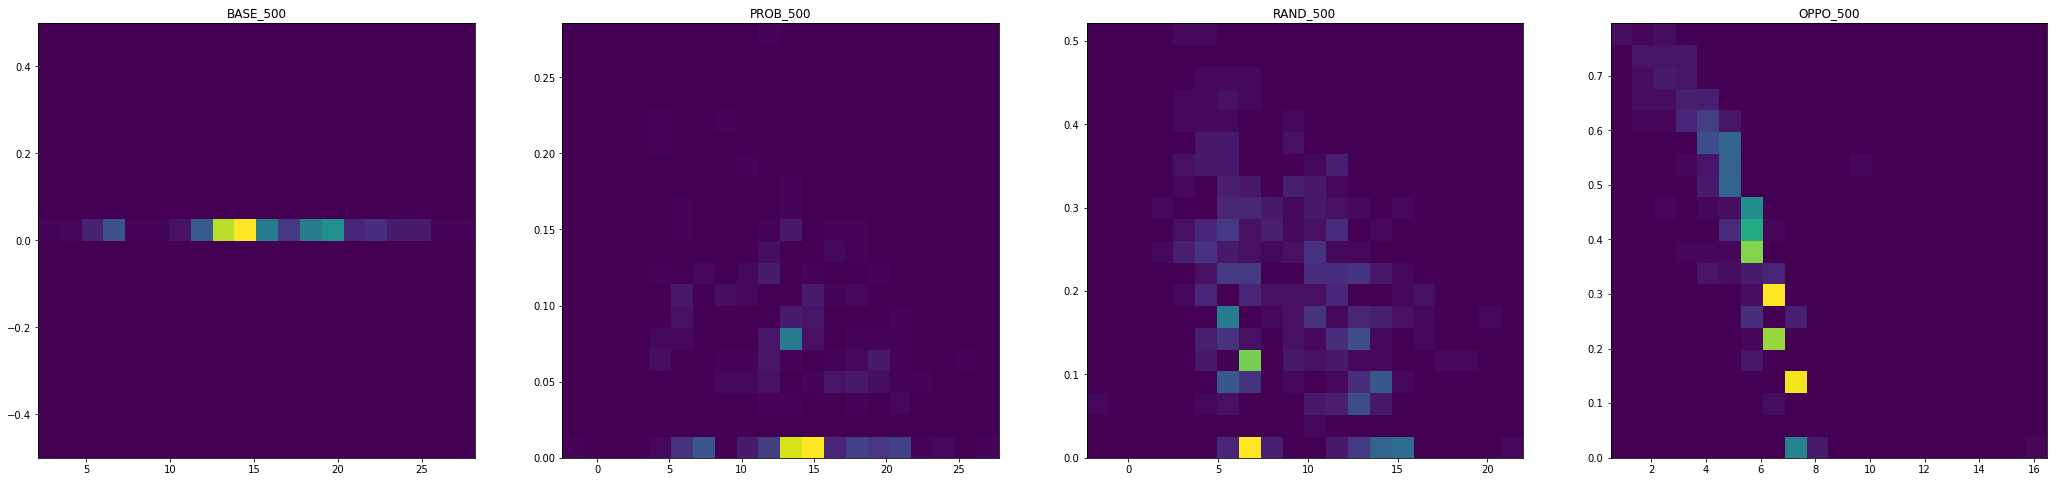

In [22]:
# visualize the histogram of "deception rates" over "discounted rewards"
plot_2d_hists(collection_array[:, [3, 0], :].tolist(), (36,8), 20, titles[0])

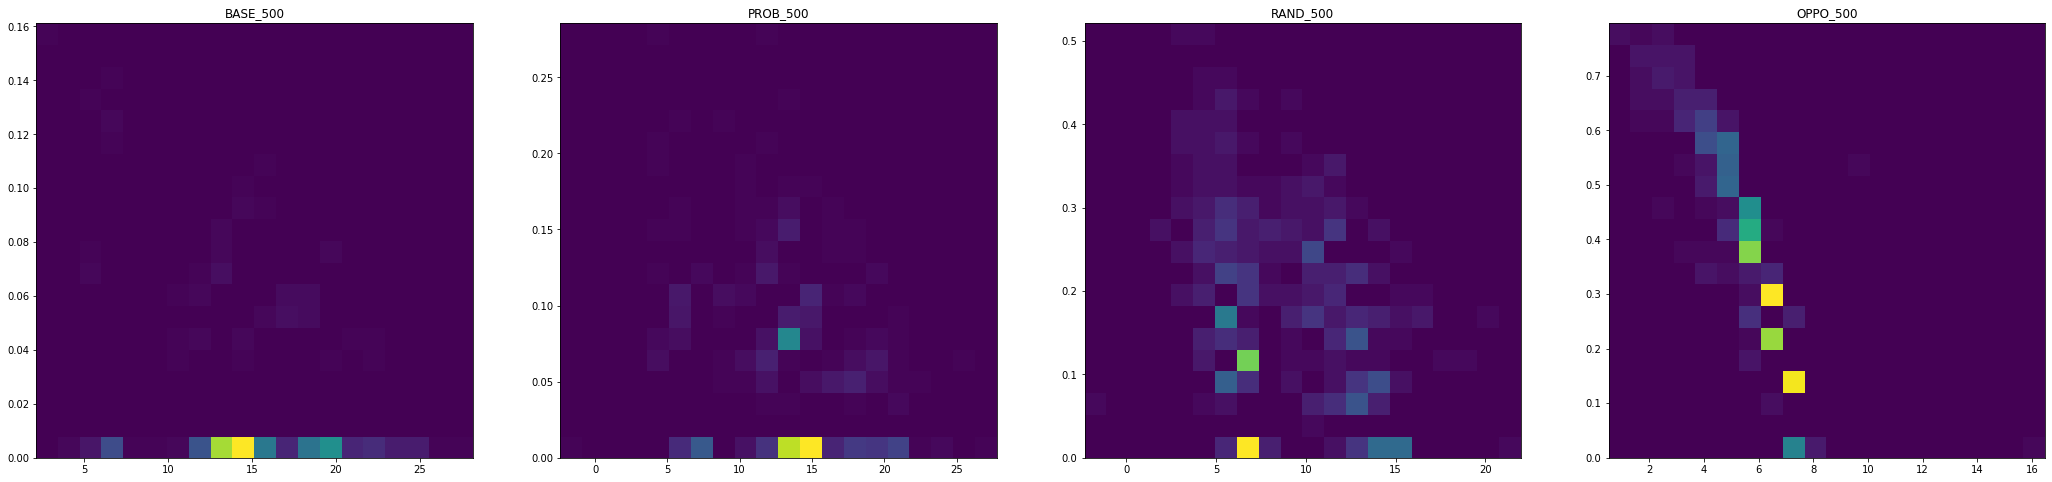

In [23]:
# visualize the histogram of "falsified rates" over "discounted rewards"
plot_2d_hists(collection_array[:, [3, 1], :].tolist(), (36,8), 20, titles[0])

In [24]:
lists_collection_200 = []
for i, exp in enumerate(experiment_set_200):
    obs_stat_dict = get_obs_stat(exp)
    # deception_rates, falsified_rates, undiscounted, discounted
    exp_lsts = list(analyze_obs_stat(obs_stat_dict, exp))
    print(reward_print_msg.format(titles[0][i], mean(exp_lsts[2]), mean(exp_lsts[3]),\
        min(exp_lsts[2]), max(exp_lsts[2]), min(exp_lsts[3]), max(exp_lsts[3])))
    lists_collection_200.append(exp_lsts)
    
collection_array = np.asarray(lists_collection_200)

Experiment: BASE_500, avg undiscounted return: 23.10, avg discounted return: 15.11;
-- Undiscounted range: [10.00, 50.00], discounted range: [4.40, 27.85]

Experiment: PROB_500, avg undiscounted return: 21.85, avg discounted return: 13.62;
-- Undiscounted range: [10.00, 60.00], discounted range: [2.50, 25.90]

Experiment: RAND_500, avg undiscounted return: 15.40, avg discounted return: 9.19;
-- Undiscounted range: [10.00, 30.00], discounted range: [1.22, 19.85]

Experiment: OPPO_500, avg undiscounted return: 10.00, avg discounted return: 5.78;
-- Undiscounted range: [10.00, 10.00], discounted range: [1.84, 7.74]



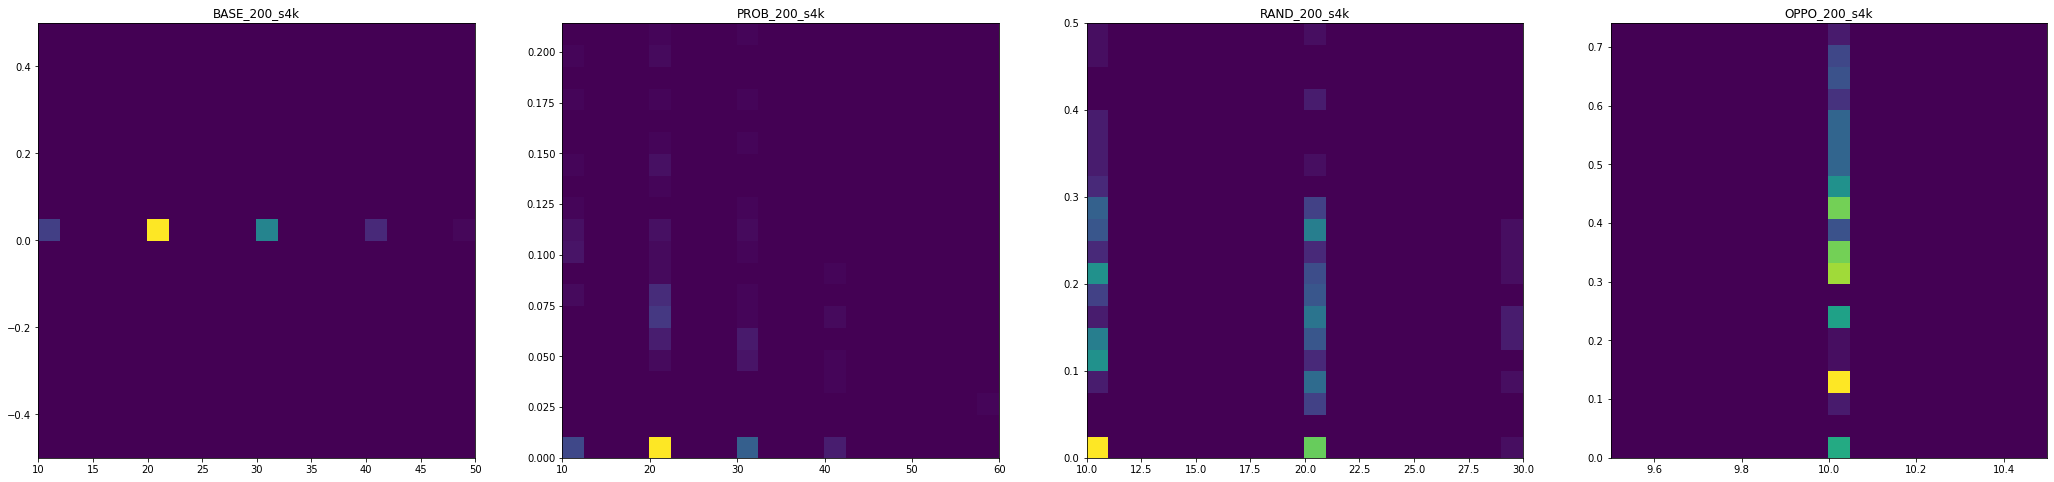

In [25]:
# visualize the histogram of "deception rates" over "undiscounted rewards"
plot_2d_hists(collection_array[:, [2, 0], :].tolist(), (36,8), 20, titles[1])

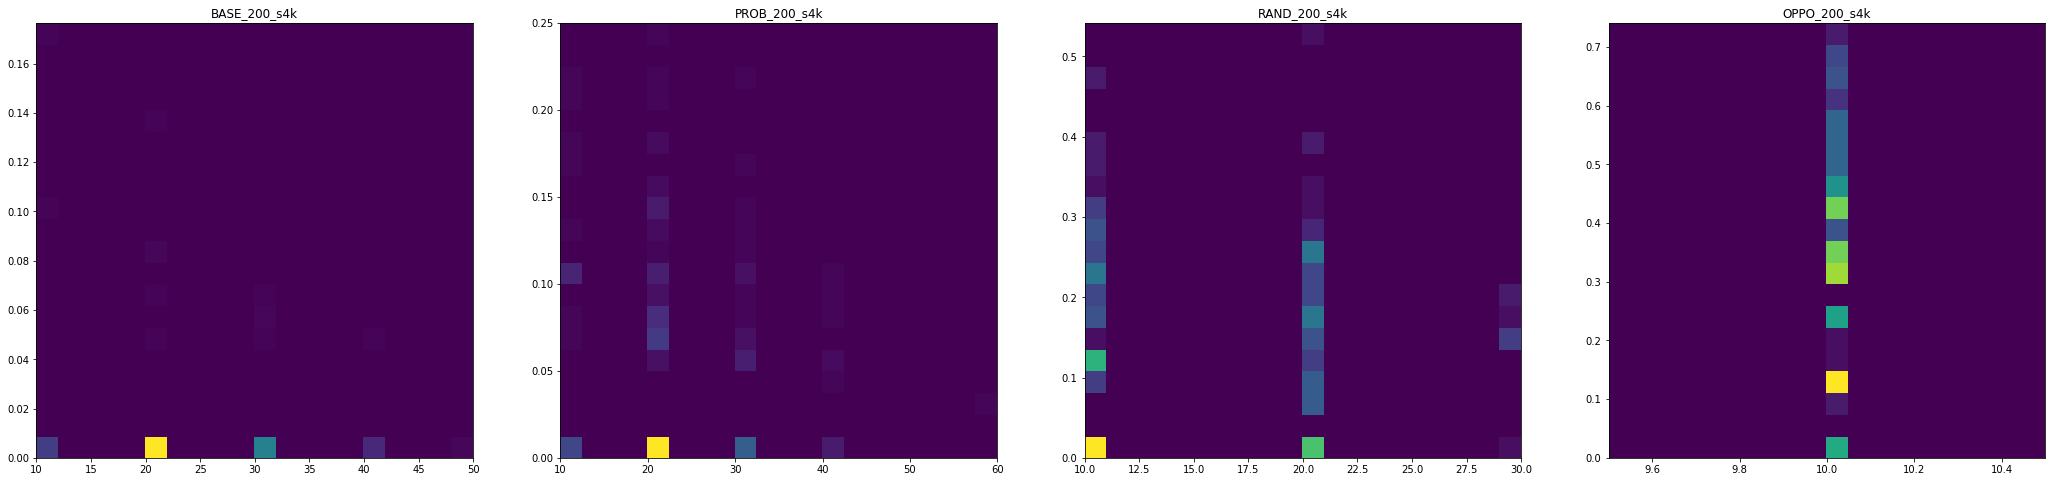

In [26]:
# visualize the histogram of "falsified rates" over "undiscounted rewards"
plot_2d_hists(collection_array[:, [2, 1], :].tolist(), (36,8), 20, titles[1])

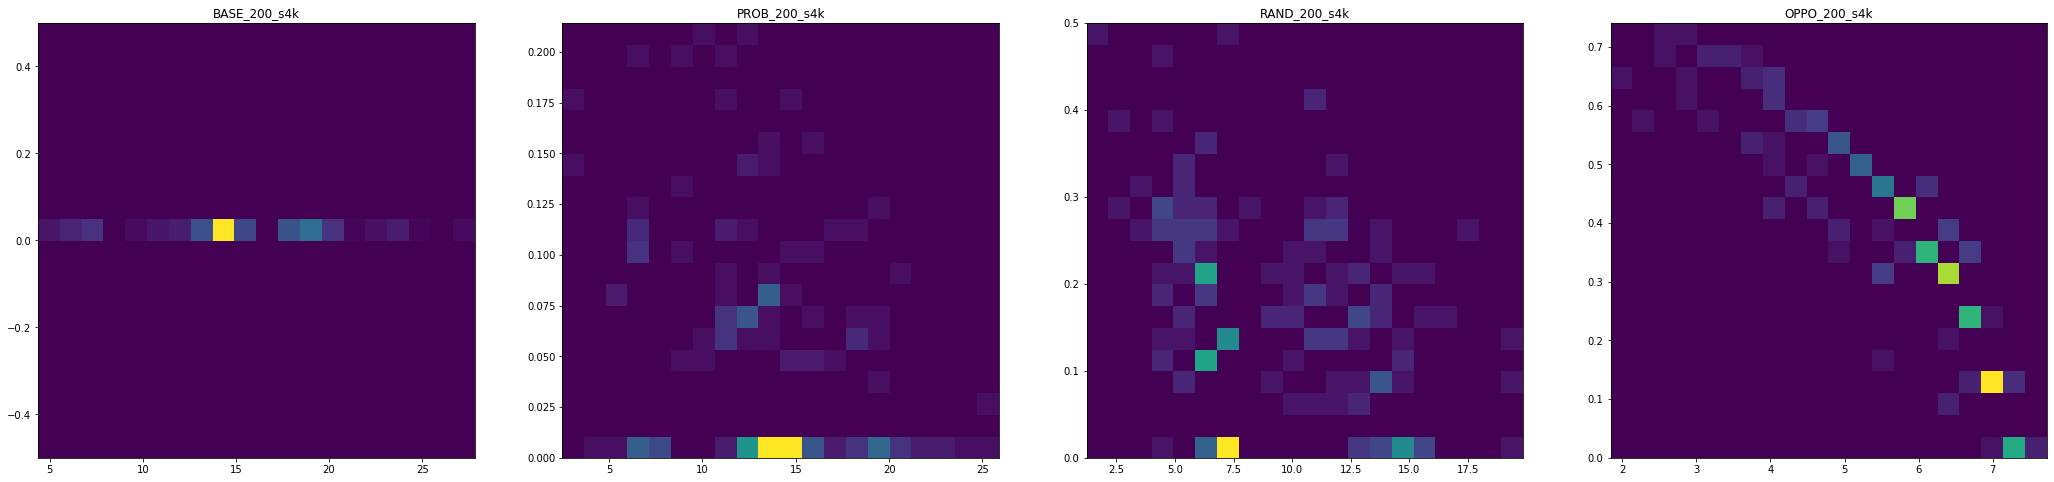

In [27]:
# visualize the histogram of "deception rates" over "discounted rewards"
plot_2d_hists(collection_array[:, [3, 0], :].tolist(), (36,8), 20, titles[1])

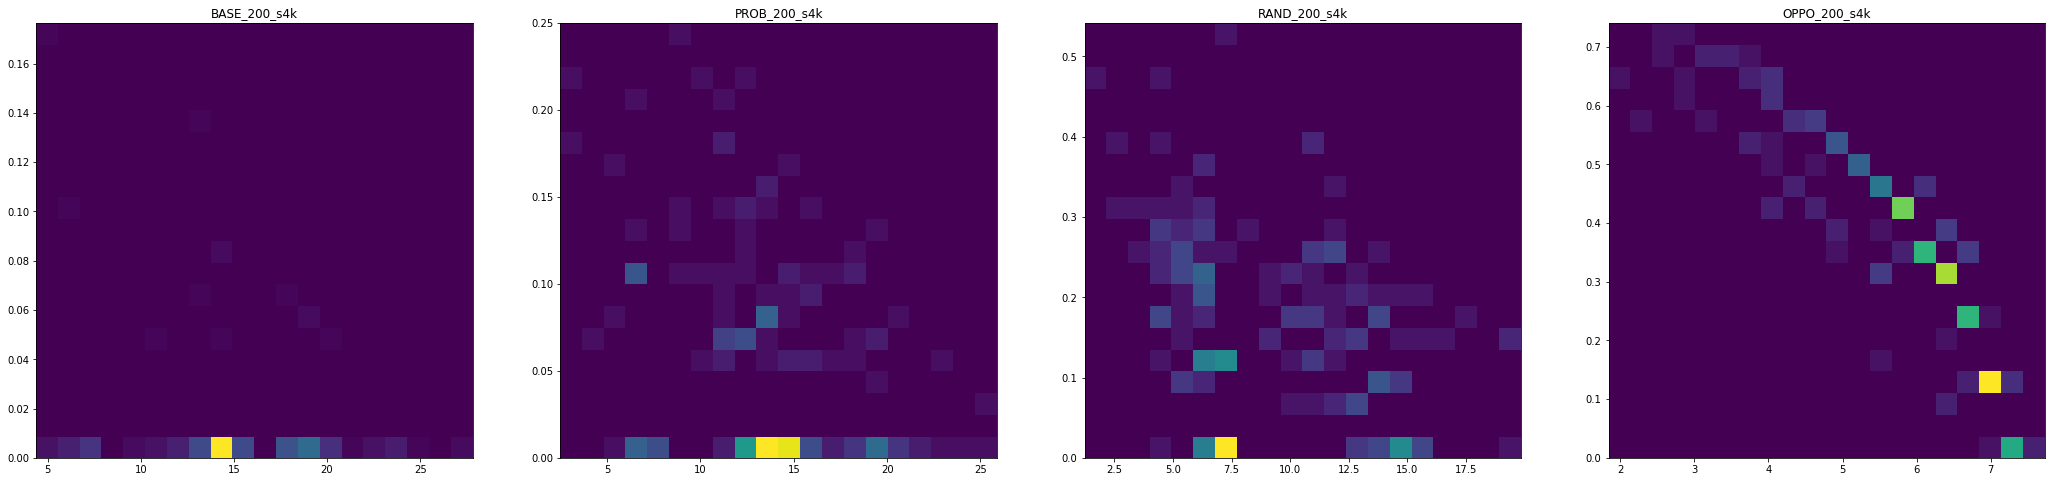

In [28]:
# visualize the histogram of "falsified rates" over "discounted rewards"
plot_2d_hists(collection_array[:, [3, 1], :].tolist(), (36,8), 20, titles[1])

<a id='p2_con'></a>
### Conclusion - Part 2

From two sets of experiments with different rollout arguments, we clearly see that the undiscounted/discounted returns across differernt kernels and baseline are of the same pattern:

- Baseline has highest return, Prob kernel has second, Rand third, Oppo has lowest return. This is in accordance with the ranking of correct rates from four experiments. $O > Prob(O) > Rand(O) > Oppo(O)$ 

- We further define falsified rate $f\_rate$ and deceptive rate $d\_rate$ as: 

    $f\_rate = \frac{falsified\_obs}{total\_obs}$

    $d\_rate = \frac{deceptive\_obs}{total\_obs}$
    
    We present the 2D Histogram between f_rate/d_rate and discounted/undiscounted return.
    
- We first show that falsified observations are strongly correlated to deceptive observations. 

- The deceptions resulted from 3 kernels are of different sorts. Oppo kernel is obviously most deadly and it forbids all correctness from observation.

- Compared to Prob kernel, Rand kernel allows much fewer players to successfully sample a single good rock, which is very easy in baseline case.

[Jump back to start](#analysis_start)

<a id='Part_3'></a>
### Analysis Part 3

In this part we try to discuss if the deceptive kernel contribute to a longer/shorter process of decision-makings by the agents. 

- [Jump back to start](#analysis_start)
- [Jump to conclusion](#p3_con)

In [29]:
steps_print_msg = "Experiment: {}; average steps number: {}\n\
-- Min: {:d}, Max: {:d}"

Experiment: BASE_500; average steps number: 14.212
-- Min: 6, Max: 32
Experiment: PROB_500; average steps number: 13.876
-- Min: 6, Max: 49
Experiment: RAND_500; average steps number: 14.652
-- Min: 6, Max: 66
Experiment: OPPO_500; average steps number: 12.862
-- Min: 6, Max: 59


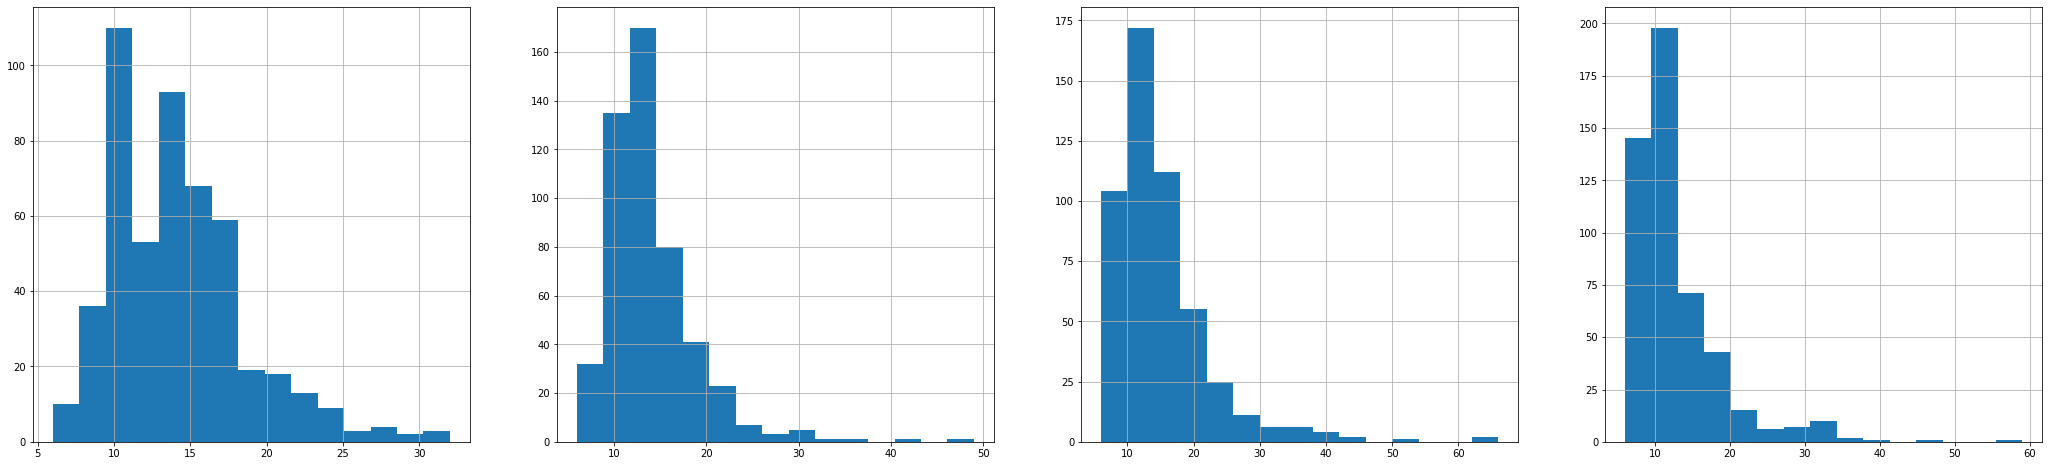

In [30]:
_, axs = plt.subplots(1, len(experiment_set_500), figsize=(36, 8))

for i, exp in enumerate(experiment_set_500):
    steps_no_list = get_steps_no(exp).values()
    print(steps_print_msg.format(titles[0][i], mean(steps_no_list), \
          min(steps_no_list), max(steps_no_list)))
    axs[i].hist(steps_no_list, bins=15)
    axs[i].grid()

Experiment: BASE_200_s4k; average steps number: 14.015
-- Min: 7, Max: 38
Experiment: PROB_200_s4k; average steps number: 14.515
-- Min: 7, Max: 40
Experiment: RAND_200_s4k; average steps number: 13.445
-- Min: 6, Max: 42
Experiment: OPPO_200_s4k; average steps number: 12.23
-- Min: 6, Max: 34


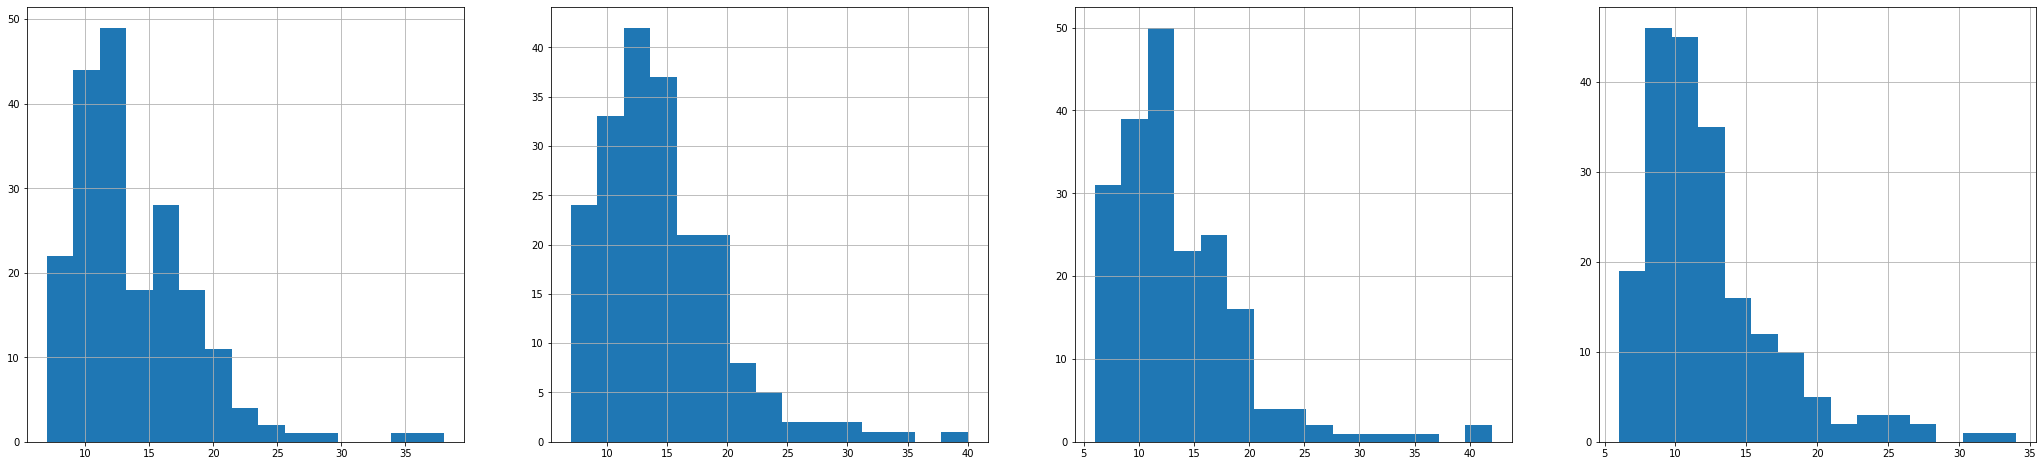

In [31]:
_, axs = plt.subplots(1, len(experiment_set_200), figsize=(36, 8))

for i, exp in enumerate(experiment_set_200):
    steps_no_list = get_steps_no(exp).values()
    print(steps_print_msg.format(titles[1][i], mean(steps_no_list), \
          min(steps_no_list), max(steps_no_list)))
    axs[i].hist(steps_no_list, bins=15)
    axs[i].grid()

<a id='p3_con'></a>
### Conclusion - Part 3

- The Prob kernel and Rand kernel don't show obvious evidence that they can shorten the process.

- The Oppo kernel encourages a shorter decision-making. Due to the nature of Monte-Carlo Tree Search algorithm applied in the experiment, the algorithm tends to choose a quicker way out to the exit area and gets the exit reward, instead of wandering around in the map.

[Jump back to start](#analysis_start)

<a id='Part_4'></a>
### Analysis Part 4

In this part we discuss if the deception kernel misleads the agent's correct belief. Further, we find if the deception kernel successfully leads the agent to mis-sample a wrong position/bad rock or to overlook a good rock.

    - get a deceptive & falsified observation, didn't visit that rock position
    - get a deceptive & falsified observation, visit the position, but incorrectly sample
        - incorrectly sample: 
            1. Actual: pos, Observe: neg, didn't sample
            2. Actual: neg, Observe: pos, sample got punished
        - on the contrary, correct sample:
            1. Actual: pos, Observe: neg, still sample
            2. Actual: neg, Observe: pos, didn't sample

- [Jump back to start](#analysis_start)
- [Jump to conclusion](#p4_con)

In [32]:
belief_change_msg = "Total # of obs: {:d}; # of belief changes: {:d};\n\
False Belief changes: {:d}; Deceived Belief changes: {:d}\n"

belief_change_rate_msg = "Total % of obs: {:.2f}; % of belief changes: {:.2f};\n\
% False obs changes: {:.2f}; % Deceived obs changes: {:.2f}\n\n"+med_bar+"\n"

obs_stat_msg = \
"Experiment: {}\n\
- Original Observations - TP+FN: {:d}, TN+FP: {:d}\n\
- Deceived Observations - TP+FN: {:d}, TN+FP: {:d}\n\
- True ignored obs:     {:d}\n\
- Deceived ignored obs: {:d}\n"

In [33]:
for i, exp in enumerate(experiment_set_500):
    
    t_stat, d_stat, t_ignore, d_ignore, bc_count = \
        analyze_observation_exp(exp)
    true_succ = int(t_stat[0,0] + t_stat[1,1])
    true_fail = int(t_stat[0,1] + t_stat[1,0])
    decp_succ = int(d_stat[0,0] + d_stat[1,1])
    decp_fail = int(d_stat[0,1] + d_stat[1,0])
    print(obs_stat_msg.format(titles[0][i], true_succ, true_fail, \
            decp_succ, decp_fail, t_ignore, d_ignore))
    print(belief_change_msg.format(*bc_count.astype(int).tolist()))
    
    print(belief_change_rate_msg.format(*(bc_count/bc_count[0]).tolist()))

Experiment: BASE_500
- Original Observations - TP+FN: 1725, TN+FP: 35
- Deceived Observations - TP+FN: 0, TN+FP: 0
- True ignored obs:     426
- Deceived ignored obs: 0

Total # of obs: 2186; # of belief changes: 561;
False Belief changes: 28; Deceived Belief changes: 0

Total % of obs: 1.00; % of belief changes: 0.26;
% False obs changes: 0.01; % Deceived obs changes: 0.00


Experiment: PROB_500
- Original Observations - TP+FN: 1597, TN+FP: 37
- Deceived Observations - TP+FN: 85, TN+FP: 83
- True ignored obs:     360
- Deceived ignored obs: 90

Total # of obs: 2252; # of belief changes: 661;
False Belief changes: 129; Deceived Belief changes: 108

Total % of obs: 1.00; % of belief changes: 0.29;
% False obs changes: 0.06; % Deceived obs changes: 0.05


Experiment: RAND_500
- Original Observations - TP+FN: 1117, TN+FP: 30
- Deceived Observations - TP+FN: 521, TN+FP: 163
- True ignored obs:     345
- Deceived ignored obs: 696

Total # of obs: 2872; # of belief changes: 1197;
False Belie

In [34]:
for i, exp in enumerate(experiment_set_200):
    
    t_stat, d_stat, t_ignore, d_ignore, bc_count = \
        analyze_observation_exp(exp)
    true_succ = int(t_stat[0,0] + t_stat[1,1])
    true_fail = int(t_stat[0,1] + t_stat[1,0])
    decp_succ = int(d_stat[0,0] + d_stat[1,1])
    decp_fail = int(d_stat[0,1] + d_stat[1,0])
    print(obs_stat_msg.format(titles[1][i], true_succ, true_fail, \
            decp_succ, decp_fail, t_ignore, d_ignore))
    print(belief_change_msg.format(*bc_count.astype(int).tolist()))
    
    print(belief_change_rate_msg.format(*(bc_count/bc_count[0]).tolist()))

Experiment: BASE_200_s4k
- Original Observations - TP+FN: 698, TN+FP: 12
- Deceived Observations - TP+FN: 0, TN+FP: 0
- True ignored obs:     144
- Deceived ignored obs: 0

Total # of obs: 854; # of belief changes: 204;
False Belief changes: 7; Deceived Belief changes: 0

Total % of obs: 1.00; % of belief changes: 0.24;
% False obs changes: 0.01; % Deceived obs changes: 0.00


Experiment: PROB_200_s4k
- Original Observations - TP+FN: 666, TN+FP: 15
- Deceived Observations - TP+FN: 45, TN+FP: 38
- True ignored obs:     160
- Deceived ignored obs: 46

Total # of obs: 970; # of belief changes: 335;
False Belief changes: 77; Deceived Belief changes: 70

Total % of obs: 1.00; % of belief changes: 0.35;
% False obs changes: 0.08; % Deceived obs changes: 0.07


Experiment: RAND_200_s4k
- Original Observations - TP+FN: 389, TN+FP: 8
- Deceived Observations - TP+FN: 180, TN+FP: 56
- True ignored obs:     116
- Deceived ignored obs: 242

Total # of obs: 991; # of belief changes: 395;
False Belie

<a id='p4_con'></a>
### Conclusion - Part 4

First, we look at the belief-changer observations. 

- With deceptive kernel, the agent generally takes more "Checking" actions. 

- Further, the deception drives more belief-changings, these are potentially the critical point when the agents given up a rock that he believes to be bad, but could be good actually, vice versa. This is evident as the rate of belief-changes resulted from falsified/deceived observations is generally higher under cases with deceptive kernel. It is obvious that the kernel "created" these belief-changers and misled the agent.

- Looking at the sampling statistics. 
    - TP+FN represents the cases either "<u>the agent made correct decision without deception</u>", or "<u>the agent was successfully deceived</u>".
    - TN+FP represents the cases either "<u>the agent made wrong decision without deception</u>", or "<u>the agent was not successfully deceived</u>".
    
In baseline model, all observations are original, no deceived observation. Original means the observation, although is noisy, is not deceived by the kernel. And we see that the wrong decision made as a result of model noise is arond <u>0.02</u>.

With Prob kernel, we saw more deceived observations. However, the success rate of deception is around <u>0.51</u>. This means that the kernel generated more deceptions but only 51% of them are effective eventually.

The success rate rises to <u>0.76</u> with Rand kernel, and approximately <u>0.97</u> with Oppo kernel.


[Jump back to start](#analysis_start)

<a id='Part_5'></a>
### Analysis Part 5

In this part we present the visualization of agent's path choices in the map.

- [Jump back to start](#analysis_start)
- [Jump to conclusion](#p5_con)

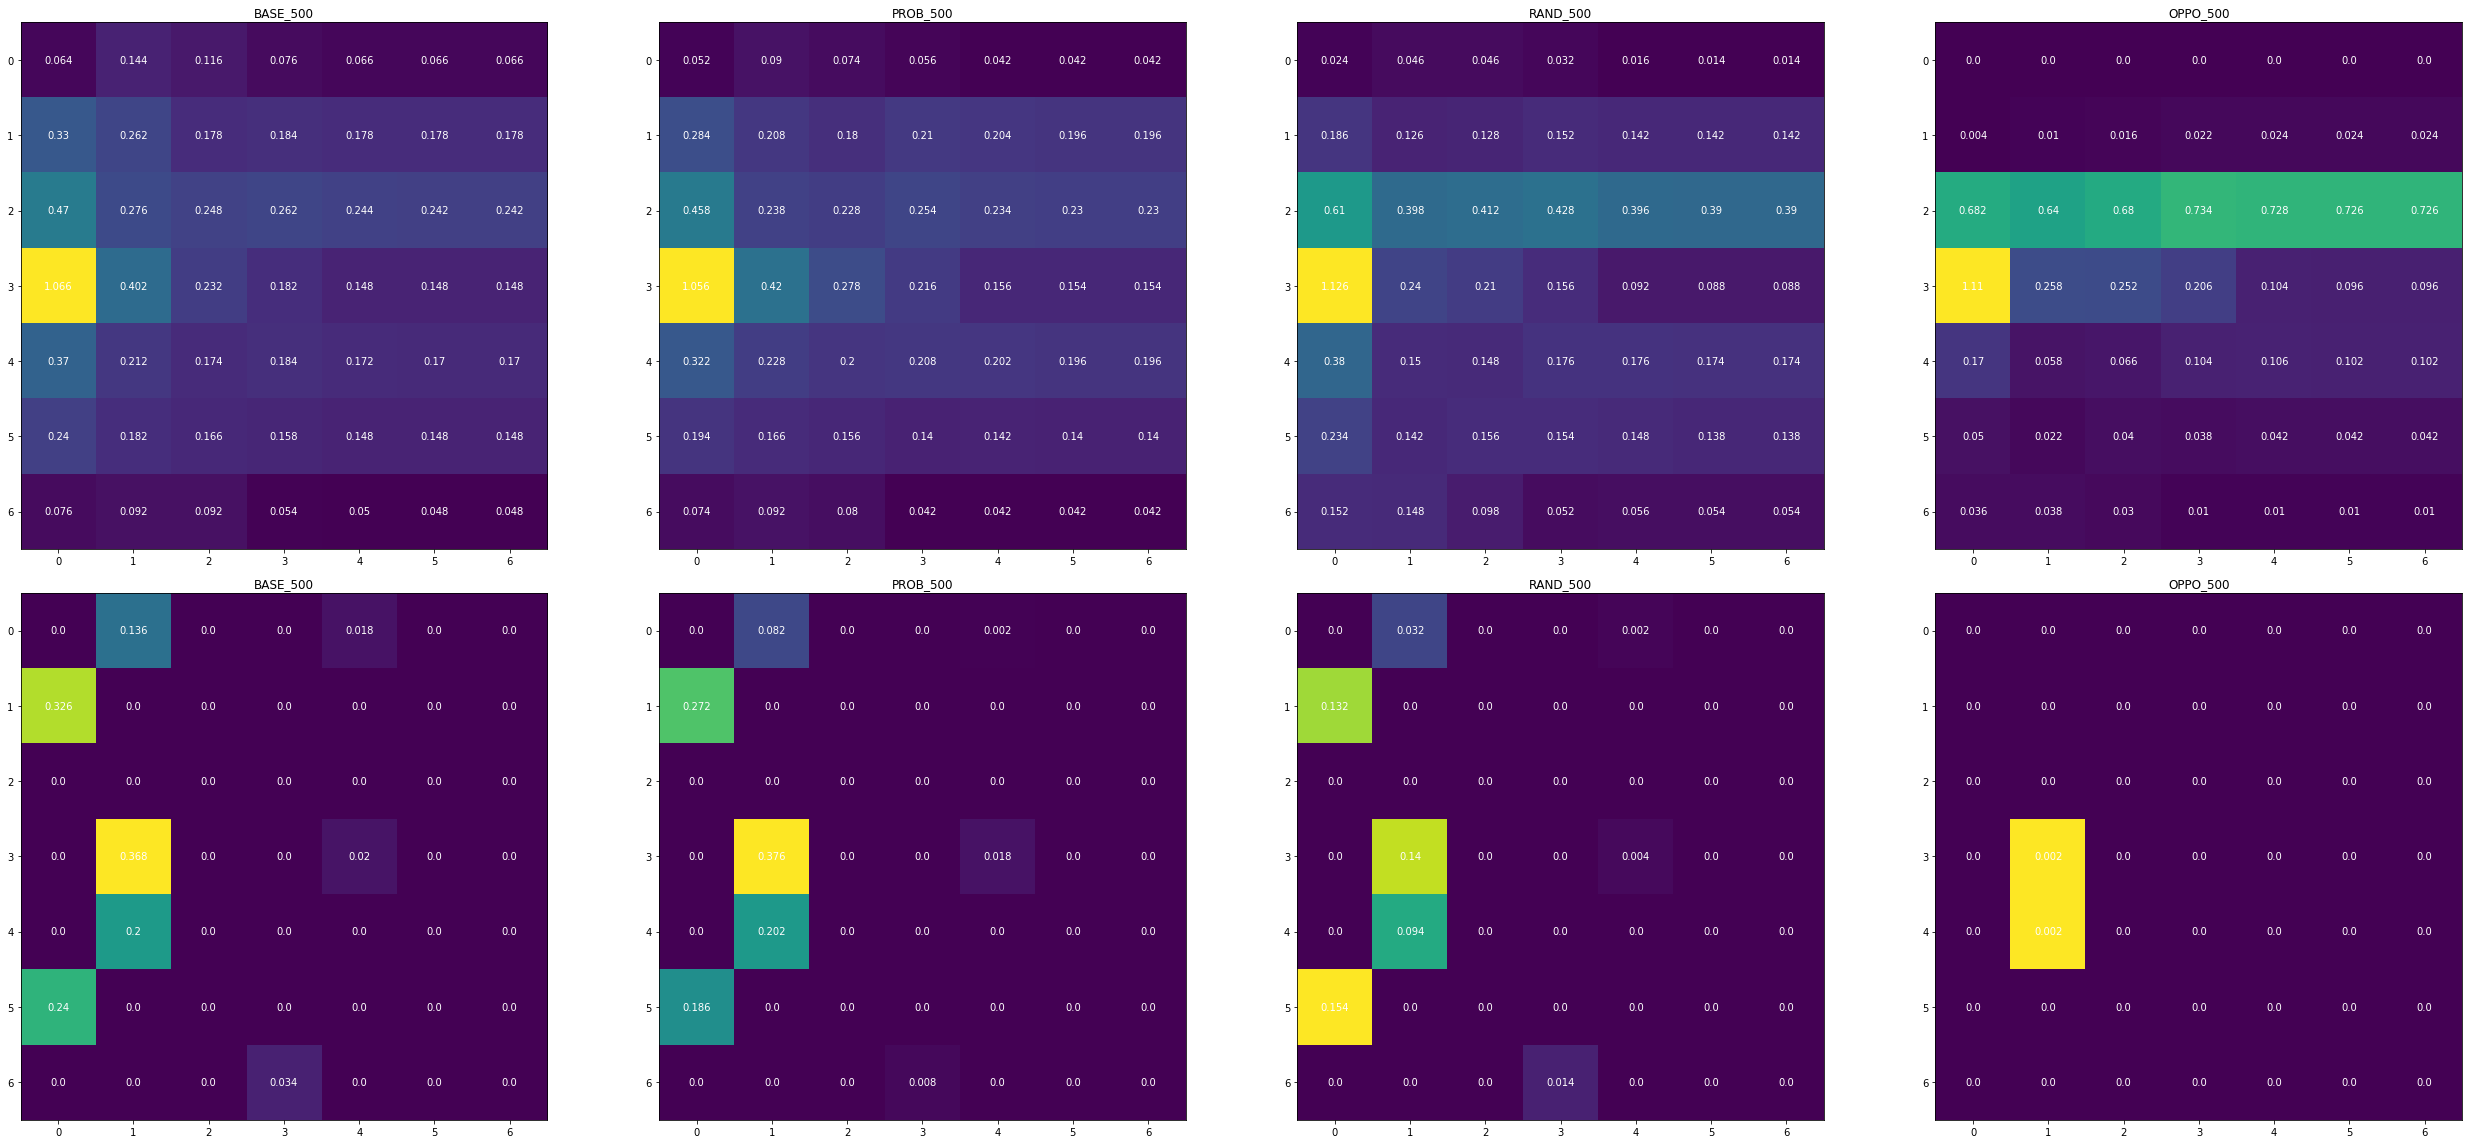

In [35]:
show_heatmaps(experiment_set_500, (36, 16), titles[0])

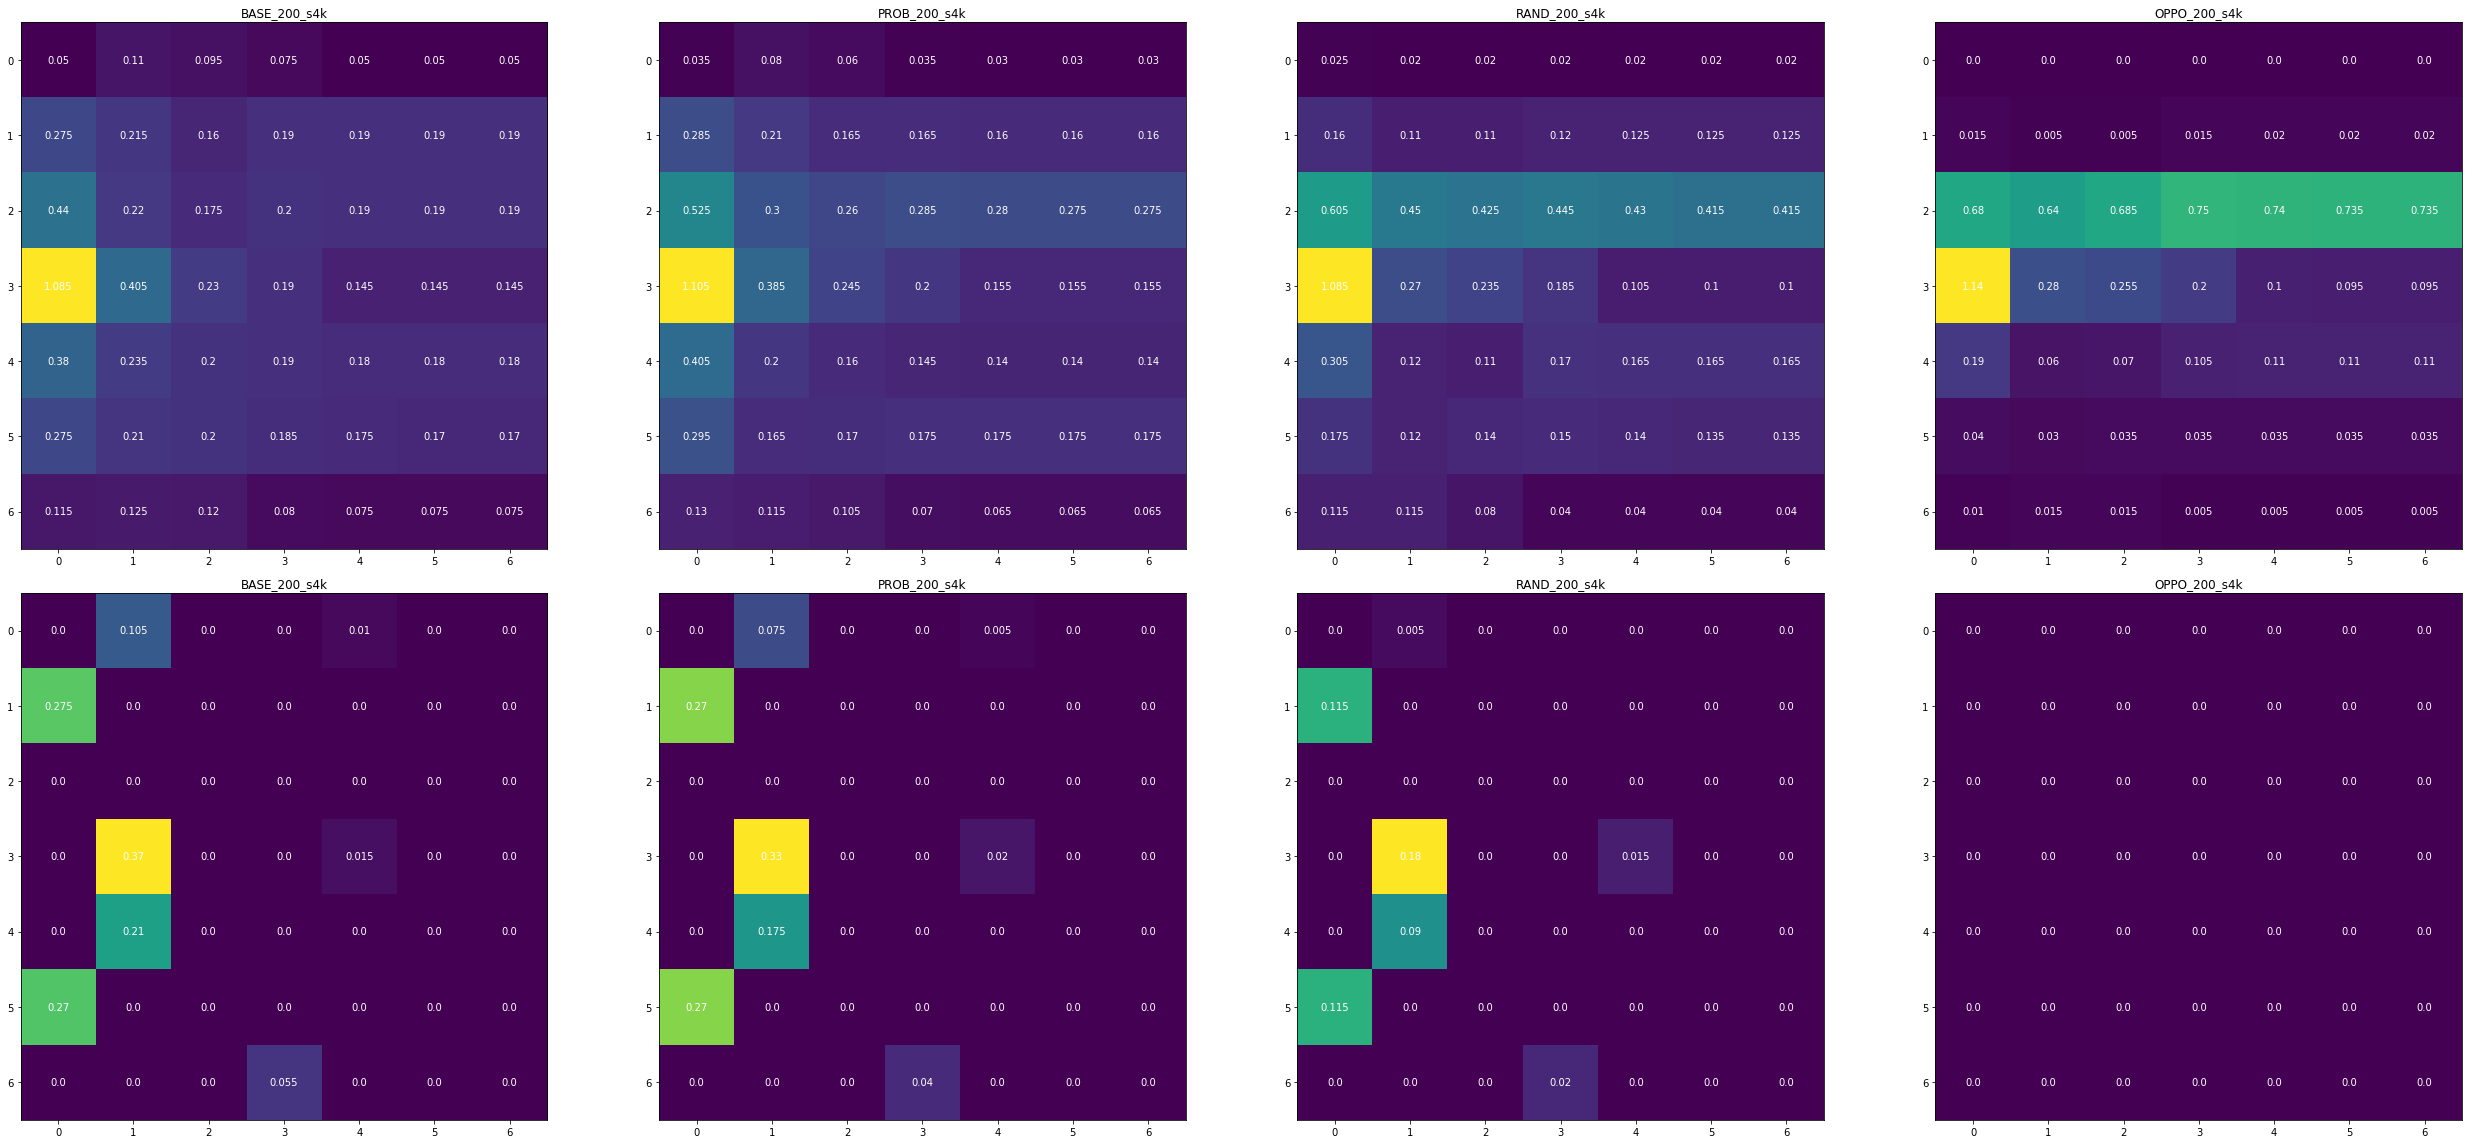

In [36]:
show_heatmaps(experiment_set_200, (36, 16), titles[1])

<a id='p5_con'></a>
### Conclusion - Part 5

The heatmap directly shows the average path choices of the agent under four experiments, with and without kernel. As the kernel gets more "effective" and more "deceptive", the paths chosen by the agent get even more limited. Instead of exploration, the agent prefers to reach the exit area soon.

[Jump back to problem spec](#rocksample)

[Jump back to start](#analysis_start)